# Classification and Clustering
October 23 2023

***

## [Palmer Penguins Dataset](https://github.com/allisonhorst/palmerpenguins)

![](https://raw.githubusercontent.com/allisonhorst/palmerpenguins/main/man/figures/logo.png)

This dataset is hosted in the original [`palmerpeguins`](https://github.com/allisonhorst/palmerpenguins) repository.

It is also available through [`seaborn`](https://seaborn.pydata.org/index.html), a popular data-viz library.

You can access this data in two ways:

- [Download the data here!](https://github.com/mwaskom/seaborn-data/raw/master/penguins.csv) and use the `.csv` file.
- Using `seaborn.load_dataset()`


All artwork and data by [@allison_horst](https://github.com/allisonhorst/palmerpenguins)

In [419]:
from math import log2
from statistics import mean
from subprocess import call

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    mean_squared_error,
    silhouette_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text

In [420]:
df = sns.load_dataset("penguins")

In [421]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [422]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [423]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


![](https://raw.githubusercontent.com/allisonhorst/palmerpenguins/main/man/figures/lter_penguins.png)

## Decision Trees

#### Example Decision Tree: Should I surf?

![](https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/cdp/cf/ul/g/ce/ed/ICLH_Diagram_Batch_03_24A-AI-ML-DecisionTree.png)

Image Credit: IBM

#### Types of Decision Trees (Fun words) - Where do we split?
- `ID3` “Iterative Dichotomiser 3” - Uses _entropy_ and _information gain_ to evaluate splits.
- `C4.5` - An iteration of ID3. Uses information gain or gain ratios to evaluate splits.
- `CART` “classification and regression trees” - Uses "Gini Impurity" to evaluate splits.

##### Entropy

This is a term that measures the 'impurity' of a sample's values.

For a set S:
$$ E(S) = -\sum_{i}p_i\log_{2}p_i$$

$p_i$ is the probability of class $i$. Compute it as the proportion of datapoints in a class.

Ex: If we have 3 red circles and 2 blue squares: $$p_{red} = \frac{3}{5}$$

<div class="alert" style="background-color:#6e420c; color: #fff"><strong>Question:</strong> 
    What is the entropy if all datapoints belong to the same class?
</div>


<div class="alert" style="background-color:#000080; color: #fff"><strong>Question:</strong> 
    Calculate the entropy of the a dataset with 2 Blue Squares and 3 Red Circles
</div>

In [424]:
def calc_entropy(*num_shapes):
    proportions = [x / sum(num_shapes) for x in num_shapes]
    return (-1) * sum([x * log2(x) for x in proportions])


calc_entropy(2, 3)

0.9709505944546686

In [425]:
calc_entropy(2, 30)

0.3372900666170139

Entropy is derived from information theory. The higher the entropy the more the information content.


##### Information Gain

Let's step it up a bit.

If we have a set of features, we want to know which feature is most useful to discriminate between classes. Information gain tells us this.


$$ IG = E(parent) - avg(E(children)) $$

Let's take the dataset above: 2 Blue Squares and 3 Red Circles and split it:

- Set 1: 1 BS, 1 RC
- Set 2: 1 BS, 2 RC

In [426]:
e_parent = calc_entropy(2, 3)
e_child1 = calc_entropy(1, 1)
e_child2 = calc_entropy(1, 2)

IG = e_parent - mean([e_child1, e_child2])
IG

0.011802677427423802

Tree Building Algorithm:
1. Choose attribute a with the highest IG as the root.
2. Construct child nodes for each value of attribute a.
3. Repeat recursively.

<div class="alert" style="background-color:#6e420c; color: #fff"><strong>Question:</strong> 
    Is the information gain value constant for any set of data S?
</div>



##### Gini Impurity

If you pick a random point in S, and classify it based on the class distribution, what is the probability that you classify it incorrectly?

In our example of 2 Blue Squares and 3 Red Circles, we'd classify a random point as a Blue Square 40% of the time.



For C classes, where $p(i)$ is the probability of picking a datapoint with class $i$:

$$
G =\sum_{i=1}^{C}p(i)(1-p(i))
$$


In our example of 2 Blue Squares and 3 Red Circles, $p(r) = 0.6$ and $p(b) = 0.4$

$$
\begin{align}
G &= p(r)(1-p(r)) + p(b)(1-p(b))\\
&= (0.6 * 0.4) + (0.4 * 0.6)\\
&= 0.48
\end{align}
$$

A Gini Impurity of 0 is the lowest and best possible impurity. 

All leaf nodes have an impurity of 0.

When using Gini Impurity, you determine split quality by weighting the impurity of each branch by how many elements it has.


In [427]:
df = sns.load_dataset("penguins")
df = df.dropna()

`species`, `island`, and `sex` are not numeric columns, and we'd like them to be numeric to use them in algorithms.

Let's use `sklearn`'s `LabelEncoder` and `OrdinalEncoder` to do this!

Generally, we use `LabelEncoder` for targets, and `OrdinalEncoder` for features.

[Docs](https://scikit-learn.org/stable/modules/preprocessing_targets.html)
[GitHub](https://github.com/scikit-learn/scikit-learn/issues/12720#issuecomment-444255844)

In [428]:
le = LabelEncoder()
oe = OrdinalEncoder().set_output(transform="pandas")

df["species"] = le.fit_transform(df["species"])
df[["sex", "island"]] = oe.fit_transform(df[["sex", "island"]])

In [429]:
x = df.drop(["species"], axis=1)
y = df["species"]

In [430]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [431]:
dtree = DecisionTreeClassifier(criterion="gini", random_state=0)
dtree.fit(x_train, y_train)
print(classification_report(y_test, dtree.predict(x_test), target_names=le.classes_))

              precision    recall  f1-score   support

      Adelie       0.93      0.96      0.95        27
   Chinstrap       0.94      0.88      0.91        17
      Gentoo       1.00      1.00      1.00        23

    accuracy                           0.96        67
   macro avg       0.96      0.95      0.95        67
weighted avg       0.96      0.96      0.95        67



![](figs/gini.png)

### Working through the D-Tree

In [432]:
random_penguin = df.sample()
random_penguin

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
312,2,0.0,45.5,14.5,212.0,4750.0,0.0


`random_penguin` still has the encoded values, this is a quick easy fix!

In [433]:
random_penguin["species"] = le.inverse_transform(random_penguin["species"])
random_penguin[["sex", "island"]] = oe.inverse_transform(
    random_penguin[["sex", "island"]]
)
random_penguin

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
312,Gentoo,Biscoe,45.5,14.5,212.0,4750.0,Female


In [434]:
dtree = DecisionTreeClassifier(criterion="entropy", random_state=0)
dtree.fit(x_train, y_train)
print(classification_report(y_test, dtree.predict(x_test), target_names=le.classes_))

              precision    recall  f1-score   support

      Adelie       0.93      0.96      0.95        27
   Chinstrap       0.94      0.88      0.91        17
      Gentoo       1.00      1.00      1.00        23

    accuracy                           0.96        67
   macro avg       0.96      0.95      0.95        67
weighted avg       0.96      0.96      0.95        67



![](figs/entropy.png)

In [435]:
tree_str = export_text(
    dtree,
    feature_names=x_train.columns,
    class_names=["Adelie", "Gentoo", "Chinstrap"],
)
print(tree_str)

|--- flipper_length_mm <= 206.00
|   |--- bill_length_mm <= 42.35
|   |   |--- bill_depth_mm <= 16.65
|   |   |   |--- bill_length_mm <= 39.50
|   |   |   |   |--- class: Adelie
|   |   |   |--- bill_length_mm >  39.50
|   |   |   |   |--- class: Gentoo
|   |   |--- bill_depth_mm >  16.65
|   |   |   |--- class: Adelie
|   |--- bill_length_mm >  42.35
|   |   |--- body_mass_g <= 4062.50
|   |   |   |--- class: Gentoo
|   |   |--- body_mass_g >  4062.50
|   |   |   |--- bill_length_mm <= 47.20
|   |   |   |   |--- class: Adelie
|   |   |   |--- bill_length_mm >  47.20
|   |   |   |   |--- sex <= 0.50
|   |   |   |   |   |--- class: Chinstrap
|   |   |   |   |--- sex >  0.50
|   |   |   |   |   |--- class: Gentoo
|--- flipper_length_mm >  206.00
|   |--- island <= 0.50
|   |   |--- class: Chinstrap
|   |--- island >  0.50
|   |   |--- bill_depth_mm <= 19.25
|   |   |   |--- class: Adelie
|   |   |--- bill_depth_mm >  19.25
|   |   |   |--- class: Gentoo



<div class="alert" style="background-color:#6e420c; color: #fff"><strong>OPTIONAL</strong> 
    The next cell is requires <a href="https://graphviz.org/download/">GraphViz, you can download it here!</a> Uncomment it if you want to render your own tree(s).
</div>


In [436]:
# export_graphviz(
#     dtree,
#     out_file="penguins.dot",
#     feature_names=x_train.columns,
#     class_names=["Adelie", "Gentoo", "Chinstrap"],
#     rounded=True,
#     proportion=False,
#     precision=2,
#     filled=True,
# )
# call(['dot', '-Tpng', 'penguins.dot', '-o', 'penguintree.png', '-Gdpi=500'])

## Support Vector Machine

- Maps data to a high dimensional space.
- Uses a hyperplane to classify data.


Pros:
- Effective in high dimensional spaces
- Memory efficient

Cons:
- Does not perform well when data has noise

#### How do we find a good hyper-plane (decision surface)?


Let's start with this basic example, to separate stars from dots. This is an extremely basic 2-D problem, that can be solved in 2-D so our hyperplane can just be a line.

![](figs/goodplane.png)

This is a pretty simple problem and we see that the dashed green line separates the two groups well. The green line does not mis-classify points, nothing touches that line, and it is equally far away from both sets.

![](figs/badplane.png)

In this image, we see the same data, but with another line. This red line is closer to the blue dots than the stars, this is not a good hyperplane.

#### Non-Linearity

To come up with hyperplanes for non-linear data, as well as more feature vectors, we have to map points to higher dimensionalities.

![](figs/kernel-trick1.png)
Image Credit: Michael I. Jordan

We can see that it is much easier to come up with a hyperplane on the transformed data on the right.

##### Kernel Trick

SVM's rely on calculating inner products (dot products). This can be extremely inefficient in high-dimensional spaces.


We had 2D data, getting transformed into 3D data to make it linearly separable.

Let us use a mapping function $\phi$ to map 2D data to 3D data.

$\phi: \mathbb{R}^2\rightarrow\mathbb{R}^3$

To put it simply, $\phi$ is a function that turns $(x_1,x_2)$ into $(z_1,z_2,z_3)$

We *could* transform this data using $\phi$ and then compute inner products, and waste all your computational resources.

The alternative is to do all of the above in one operation, and leaving the mapping implicit. This method is called the 'Modified Inner Product' a.k.a. **Kernel** $K(x,y)$ 

![](figs/kernelmatrix.png)

We care about $K$, and not $\phi$, we can use Mercer's Theorem to characterize kernels, without knowing what $\phi$ looks like.

Ex: Gaussian Kernel
$ K(x,y) = e^{\frac{1}{2} || x - y || ^2}$

In [437]:
df = sns.load_dataset("penguins")
df = df.dropna()

`species`, `island`, and `sex` are not numeric columns, and we'd like them to be numeric to use them in algorithms.

Let's use `sklearn`'s `LabelEncoder` to do this!

In [438]:
le = LabelEncoder()
oe = OrdinalEncoder().set_output(transform="pandas")

df["species"] = le.fit_transform(df["species"])
df[["sex", "island"]] = oe.fit_transform(df[["sex", "island"]])

In [439]:
x = df.drop(["species"], axis=1)
y = df["species"]

In [440]:
x.describe().T

,count,mean,std,min,25%,50%,75%,max
island,333.0,0.651652,0.714715,0.0,0.0,1.0,1.0,2.0
bill_length_mm,333.0,43.992793,5.468668,32.1,39.5,44.5,48.6,59.6
bill_depth_mm,333.0,17.164865,1.969235,13.1,15.6,17.3,18.7,21.5
flipper_length_mm,333.0,200.966967,14.015765,172.0,190.0,197.0,213.0,231.0
body_mass_g,333.0,4207.057057,805.215802,2700.0,3550.0,4050.0,4775.0,6300.0
sex,333.0,0.504505,0.500732,0.0,0.0,1.0,1.0,1.0


While we're transforming data, let us scale the data - change the range of the data.

In [441]:
scaler = StandardScaler()

# Scale both X_train and X_test
x = scaler.fit_transform(x)
col_names = [
    "island",
    "bill_length_mm",
    "bill_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
    "sex",
]
scaled_x = pd.DataFrame(x, columns=col_names)
scaled_x.describe().T

,count,mean,std,min,25%,50%,75%,max
island,333.0,4.267524e-17,1.001505,-0.913136,-0.913136,0.488128,0.488128,1.889392
bill_length_mm,333.0,3.840772e-16,1.001505,-2.177987,-0.822788,0.092887,0.843741,2.858227
bill_depth_mm,333.0,6.401286e-16,1.001505,-2.067291,-0.795852,0.068726,0.780732,2.204743
flipper_length_mm,333.0,2.133762e-16,1.001505,-2.069852,-0.783651,-0.283462,0.859828,2.146028
body_mass_g,333.0,-1.707010e-16,1.001505,-1.874435,-0.817229,-0.195343,0.706392,2.603144
sex,333.0,7.201447e-17,1.001505,-1.009050,-1.009050,0.991031,0.991031,0.991031


In [442]:
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.1)

In [443]:
svm_classifier = SVC()
svm_classifier.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [444]:
svm_classifier.fit(x_train, y_train)

SVC()

In [445]:
svm_classifier.score(x_test, y_test)

1.0

In [446]:
print(
    classification_report(
        y_test, svm_classifier.predict(x_test), target_names=le.classes_
    )
)

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        15
   Chinstrap       1.00      1.00      1.00         8
      Gentoo       1.00      1.00      1.00        11

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



Can we do better?

The `gamma` hyper-parameter is used for non-linear hyperplanes. The nigher the gammma value, the more the model tries to fit the training set. Extremely high gamma leads to overfitting.

In [447]:
gamma_list = np.linspace(0.00, 2, 100)
scores = [
    cross_val_score(SVC(gamma=g), x_train, y_train, cv=5).mean() for g in gamma_list
]
best_gamma, best_score = max(zip(gamma_list, scores), key=lambda x: x[1])

This is called a grid search, a really awkward brute force way of finding good hyper parameters.

In [448]:
svm_classifier = SVC(gamma=best_gamma)
svm_classifier.fit(x_train, y_train)
svm_classifier.score(x_test, y_test)

1.0

Text(0.5, 0, 'Gamma')

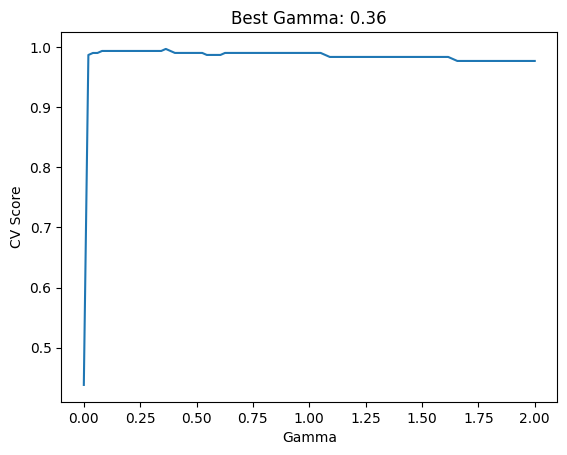

In [449]:
plt.plot(gamma_list, scores)
# plt.axvline(x = best_gamma, color = 'b', label = 'Best Gamma')
plt.title(f"Best Gamma: {round(best_gamma,2)}")
plt.ylabel("CV Score")
plt.xlabel("Gamma")

What if we didn't Scale the data?

In [450]:
x = df.drop(["species"], axis=1)
y = df["species"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
svm_classifier = SVC()
svm_classifier.fit(x_train, y_train)
print(
    classification_report(
        y_test, svm_classifier.predict(x_test), target_names=le.classes_
    )
)

              precision    recall  f1-score   support

      Adelie       0.52      1.00      0.68        13
   Chinstrap       0.00      0.00      0.00        12
      Gentoo       1.00      1.00      1.00         9

    accuracy                           0.65        34
   macro avg       0.51      0.67      0.56        34
weighted avg       0.46      0.65      0.53        34



/Users/pranav/anaconda3/envs/318/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pranav/anaconda3/envs/318/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pranav/anaconda3/envs/318/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [451]:
svm_classifier.score(x_test, y_test)

0.6470588235294118

## k-Nearest Neighbours



K- Nearest Neighbors is a

 - **Supervised machine learning algorithm**.

 - **Non parametric** as it **does not** make an **assumption** about the **underlying data distribution pattern**.

 - It doesnt have the training step, **K stands for Number of neighbours**.It uses **distance metric **like **L1 ,L2 distance** to predict the label of new point into N-dimensional space.
 
 - Can do both classification and regression task. 


How does kNN work? 
1. When a new data point arrives, the kNN algorithm will start by finding the nearest neighbors of this new data point. 
2. Then it takes the values of those neighbors and uses them as a prediction for the new data point.

How does it find the nearest neighbors? 
- Using different distance measure between the data points: 
    1. Euclidean Distance: straight-line distance.
    2. Manhattan Distance: sum of absolute coordinate differences.
    3. Hamming Distance: counts differing bits in binary strings.

!["kNN"](https://miro.medium.com/v2/resize:fit:1400/0*Rxd_UYjOPrK7_gk4)

source: [Italo José](https://towardsdatascience.com/knn-k-nearest-neighbors-1-a4707b24bd1d)

**Pros**:



1.   Robust to noisy data.
2.   No training phase involved as it direclty relies on labels of K nearest neighbours.
3.   Effective if training set is large.


**Cons**

1.   Difficult to choose value of K.
2.   Difficut to estimate which distance could give best result.
3.   Not effective if data has high dimensional since large storage is required,low computational efficiency, data sparsity.
4.   Classifying a new testing point requires a comparison to every single data point in our training data, which scales O(N), making working with larger datasets computationally prohibitive.

In [452]:
df = sns.load_dataset("penguins")
df = df.dropna()

`species`, `island`, and `sex` are not numeric columns, and we'd like them to be numeric to use them in algorithms.

Let's use `sklearn`'s `LabelEncoder` to do this!

In [453]:
le = LabelEncoder()
oe = OrdinalEncoder().set_output(transform="pandas")

df["species"] = le.fit_transform(df["species"])
df[["sex", "island"]] = oe.fit_transform(df[["sex", "island"]])

In [454]:
# sns.pairplot(df, diag_kind="hist", hue="species")

In [455]:
x = df.drop(["species", "bill_length_mm"], axis=1)
y = df["species"]

In [456]:
x.describe()

,island,bill_depth_mm,flipper_length_mm,body_mass_g,sex
count,333.000000,333.000000,333.000000,333.000000,333.000000
mean,0.651652,17.164865,200.966967,4207.057057,0.504505
std,0.714715,1.969235,14.015765,805.215802,0.500732
min,0.000000,13.100000,172.000000,2700.000000,0.000000
25%,0.000000,15.600000,190.000000,3550.000000,0.000000
50%,1.000000,17.300000,197.000000,4050.000000,1.000000
75%,1.000000,18.700000,213.000000,4775.000000,1.000000
max,2.000000,21.500000,231.000000,6300.000000,1.000000


In [457]:
scaler = StandardScaler()

# Scale both X_train and X_test
x = scaler.fit_transform(x)

**The scaler maintains only the data points,** and not the column names, when applied on a DataFrame.

Reorganize the data into a DataFrame again with column names

In [458]:
col_names = ["island", "bill_depth_mm", "flipper_length_mm", "body_mass_g", "sex"]
scaled_df = pd.DataFrame(x, columns=col_names)
scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
island,333.0,4.267524e-17,1.001505,-0.913136,-0.913136,0.488128,0.488128,1.889392
bill_depth_mm,333.0,6.401286e-16,1.001505,-2.067291,-0.795852,0.068726,0.780732,2.204743
flipper_length_mm,333.0,2.133762e-16,1.001505,-2.069852,-0.783651,-0.283462,0.859828,2.146028
body_mass_g,333.0,-1.707010e-16,1.001505,-1.874435,-0.817229,-0.195343,0.706392,2.603144
sex,333.0,7.201447e-17,1.001505,-1.009050,-1.009050,0.991031,0.991031,0.991031


## Classification

In [459]:
x_train, x_test, y_train, y_test = train_test_split(
    scaled_df, y, test_size=0.20, random_state=123
)

---

### Training and Predicting KNN Regression

In [460]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [461]:
predictions = knn.predict(x_test)
predictions

array([0, 0, 2, 2, 1, 0, 2, 0, 2, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 1, 2, 0,
       0, 1, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0, 2, 2, 0,
       2, 1, 1, 2, 1, 0, 2, 2, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       2])

In [462]:
accuracy = accuracy_score(y_test, predictions)
accuracy

0.835820895522388

#### Neat metric report for the model

In [463]:
print(classification_report(y_test, knn.predict(x_test), target_names=le.classes_))

              precision    recall  f1-score   support

      Adelie       0.77      0.86      0.81        28
   Chinstrap       0.76      0.65      0.70        20
      Gentoo       1.00      1.00      1.00        19

    accuracy                           0.84        67
   macro avg       0.85      0.84      0.84        67
weighted avg       0.84      0.84      0.83        67



### Finding the Best value for K


In [464]:
accuracy = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    score = accuracy_score(y_test, pred_i)
    accuracy.append(score)

Text(0, 0.5, 'Accuracy')

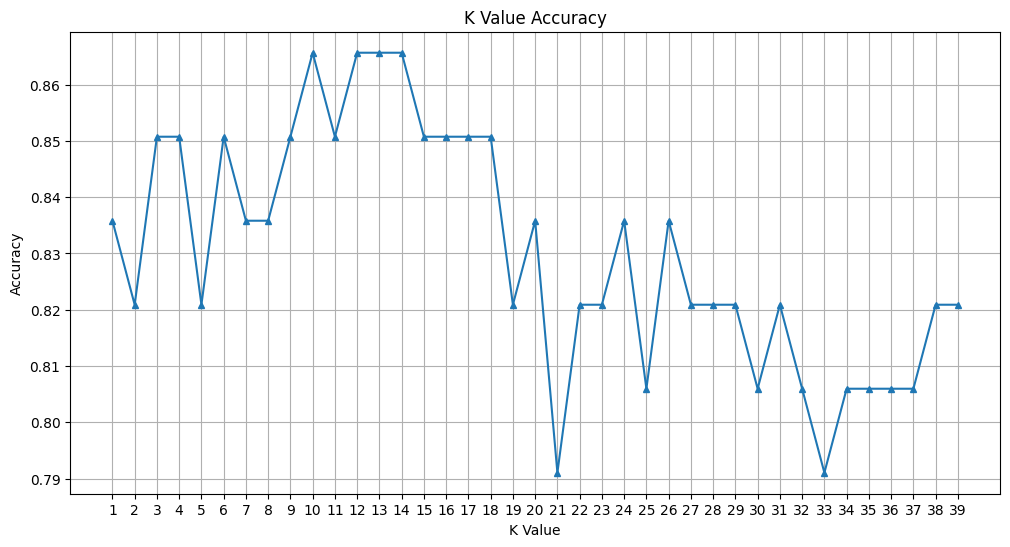

In [465]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), accuracy, marker="^", markersize=5)
plt.grid(True)
plt.xticks(range(1, 40))
plt.title("K Value Accuracy")
plt.xlabel("K Value")
plt.ylabel("Accuracy")

In [466]:
np.array(accuracy).argmax()

9

Graphing it everytime is cumbersome. Better way? 

#### Grid Search 

- A technique for hyperparameter tuning. 
    - specify a set of hyperparameters and their possible values, 
    - systematically tests all possible combinations of these hyperparameters
    - find the best set of hyperparameters for your model

In [467]:
n_neighbors = {"n_neighbors": range(1, 50)}
grid = GridSearchCV(estimator=knn, param_grid=n_neighbors)
grid.fit(x_train, y_train)
print(grid.best_score_)
print(grid.best_estimator_.n_neighbors)

0.9099930118798044
7


For kNN classification, it is recommeded to use odd values for K. Why?

## Regression

In [468]:
x = df.drop(["body_mass_g"], axis=1)
y = df["body_mass_g"]

In [469]:
scaler = StandardScaler()

# Scale both X_train and X_test
x = scaler.fit_transform(x)

In [470]:
col_names = [
    "species",
    "island",
    "bill_length_mm",
    "bill_depth_mm",
    "flipper_length_mm",
    "sex",
]
scaled_df = pd.DataFrame(x, columns=col_names)
scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
species,333.0,-1.707010e-16,1.001505,-1.034374,-1.034374,0.091268,1.216911,1.216911
island,333.0,4.267524e-17,1.001505,-0.913136,-0.913136,0.488128,0.488128,1.889392
bill_length_mm,333.0,3.840772e-16,1.001505,-2.177987,-0.822788,0.092887,0.843741,2.858227
bill_depth_mm,333.0,6.401286e-16,1.001505,-2.067291,-0.795852,0.068726,0.780732,2.204743
flipper_length_mm,333.0,2.133762e-16,1.001505,-2.069852,-0.783651,-0.283462,0.859828,2.146028
sex,333.0,7.201447e-17,1.001505,-1.009050,-1.009050,0.991031,0.991031,0.991031


Prepare the training and testing dataset

In [471]:
x_train, x_test, y_train, y_test = train_test_split(
    scaled_df, y, test_size=0.20, random_state=123
)

#### KNeighborsRegressor: fit our model.

In [472]:
parameters = {"n_neighbors": range(1, 50), "weights": ["uniform", "distance"]}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(x_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})

In [473]:
gridsearch.best_params_

{'n_neighbors': 14, 'weights': 'uniform'}

In [474]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(x_train, y_train)
pred_i = knn.predict(x_test)
mse = mean_squared_error(y_test, pred_i)
print(f"RMSE: {np.sqrt(mse)}")

RMSE: 317.1060548144737


#### Elbow method 

In [475]:
rmse = []
for i in range(1, 40):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    mse = mean_squared_error(y_test, pred_i)
    rmse.append(np.sqrt(mse))

Text(0, 0.5, 'RMSE')

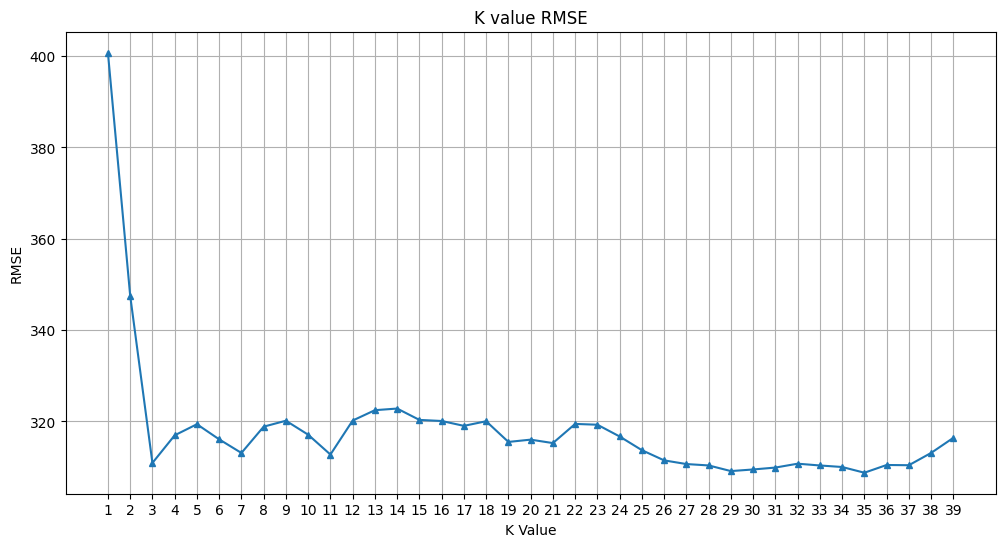

In [476]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), rmse, marker="^", markersize=5)
plt.grid(True)
plt.xticks(range(1, 40))
plt.title("K value RMSE")
plt.xlabel("K Value")
plt.ylabel("RMSE")

## K-Means Clustering


K-Means clsutering is a

 - **Unsupervised machine learning algorithm**.

 - **Centroid-Based**: centroid-based algorithm, meaning it defines clusters by finding central points (centroids) within the data.
 
 - group data points into clusters(K clusters) where each cluster represents data points that are similar to each other.



!["kmeans"](https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/KMeans2D.gif)

Image source: [Sandipan Deyn](https://sandipanweb.wordpress.com/2017/03/19/hard-soft-clustering-with-k-means-weighted-k-means-and-gmm-em/)

**Pros**

1. Relatively simple to implement.

2. Scales to large data sets.

3. Guarantees convergence.


**Cons**

1. Choosing K manually.

2. Being dependent on initial values.

3. Clustering outliers: Centroids can be dragged by outliers, or outliers might get their own cluster instead of being ignored. 


In [477]:
df = sns.load_dataset("penguins")
df = df.dropna()
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


`species`, `island`, and `sex` are not numeric columns, and we'd like them to be numeric to use them in algorithms.

Let's use `sklearn`'s `LabelEncoder` to do this!

In [478]:
le = LabelEncoder()
oe = OrdinalEncoder().set_output(transform="pandas")

df["species"] = le.fit_transform(df["species"])
df[["sex", "island"]] = oe.fit_transform(df[["sex", "island"]])

In [479]:
x = df.drop(["species"], axis=1)
y = df["species"]

In [480]:
x

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,2.0,39.1,18.7,181.0,3750.0,1.0
1,2.0,39.5,17.4,186.0,3800.0,0.0
2,2.0,40.3,18.0,195.0,3250.0,0.0
4,2.0,36.7,19.3,193.0,3450.0,0.0
5,2.0,39.3,20.6,190.0,3650.0,1.0
...,...,...,...,...,...,...
338,0.0,47.2,13.7,214.0,4925.0,0.0
340,0.0,46.8,14.3,215.0,4850.0,0.0
341,0.0,50.4,15.7,222.0,5750.0,1.0
342,0.0,45.2,14.8,212.0,5200.0,0.0


Set up training and testing dataset

In [481]:
scaler = StandardScaler()

# Scale both X_train and X_test
x = scaler.fit_transform(x)
col_names = [
    "island",
    "bill_length_mm",
    "bill_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
    "sex",
]
scaled_df = pd.DataFrame(x, columns=col_names)
scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
island,333.0,4.267524e-17,1.001505,-0.913136,-0.913136,0.488128,0.488128,1.889392
bill_length_mm,333.0,3.840772e-16,1.001505,-2.177987,-0.822788,0.092887,0.843741,2.858227
bill_depth_mm,333.0,6.401286e-16,1.001505,-2.067291,-0.795852,0.068726,0.780732,2.204743
flipper_length_mm,333.0,2.133762e-16,1.001505,-2.069852,-0.783651,-0.283462,0.859828,2.146028
body_mass_g,333.0,-1.707010e-16,1.001505,-1.874435,-0.817229,-0.195343,0.706392,2.603144
sex,333.0,7.201447e-17,1.001505,-1.009050,-1.009050,0.991031,0.991031,0.991031


In [482]:
x_train, x_test, y_train, y_test = train_test_split(
    scaled_df, y, test_size=0.10, random_state=123
)

In [483]:
x_train

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
196,0.488128,0.752174,-0.388992,-0.140551,-1.097078,-1.009050
54,-0.913136,-1.518701,-0.134704,-1.140929,-1.314738,-1.009050
178,0.488128,-0.273383,-0.236419,-0.998018,-1.065984,-1.009050
212,0.488128,1.246638,0.933305,0.645461,-0.133155,0.991031
6,1.889392,-0.877728,1.238450,-0.426373,0.582014,0.991031
...,...,...,...,...,...,...
83,0.488128,-0.932669,0.831590,-0.783651,-0.755041,-1.009050
17,-0.913136,-1.482074,1.035020,-0.855107,-0.506286,-1.009050
230,-0.913136,-0.364950,-1.863860,0.645461,-0.070966,-1.009050
98,-0.913136,-1.115804,0.729875,-0.569284,-1.594587,-1.009050


In [484]:
kmeans = KMeans(n_clusters=3, random_state=123, n_init="auto")
kmeans.fit(x_train)

KMeans(n_clusters=3, n_init='auto', random_state=123)

<Axes: ylabel='flipper_length_mm'>

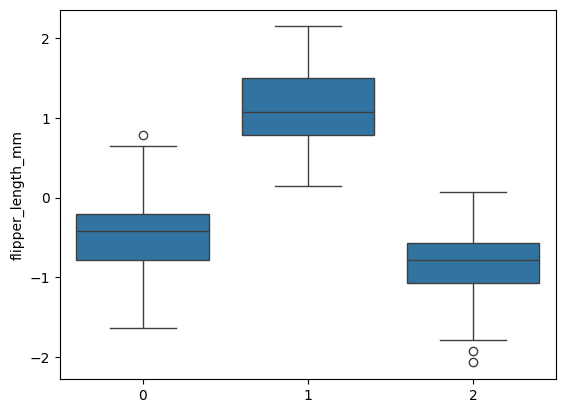

In [485]:
sns.boxplot(x=kmeans.labels_, y=x_train["flipper_length_mm"])

<Axes: ylabel='body_mass_g'>

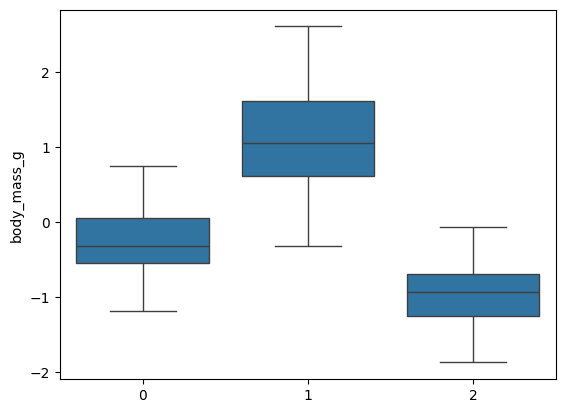

In [486]:
# ["island", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g", "sex"]
sns.boxplot(x=kmeans.labels_, y=x_train["body_mass_g"])

<Axes: ylabel='bill_depth_mm'>

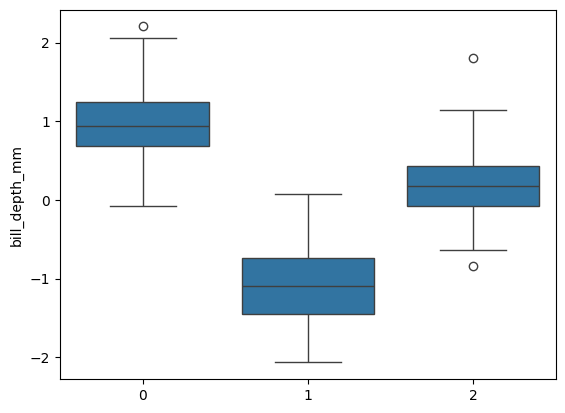

In [487]:
sns.boxplot(x=kmeans.labels_, y=x_train["bill_depth_mm"])

<Axes: xlabel='bill_length_mm', ylabel='flipper_length_mm'>

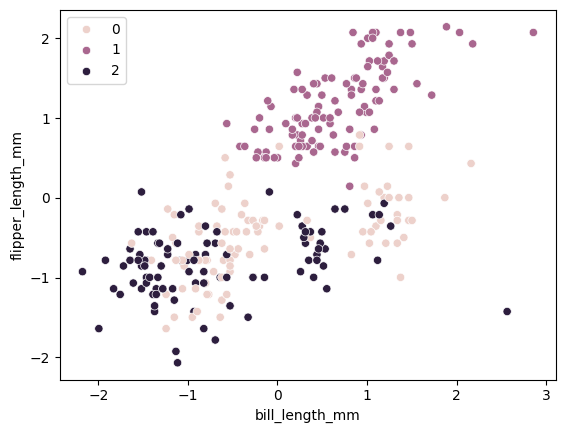

In [488]:
sns.scatterplot(
    data=x_train, x="bill_length_mm", y="flipper_length_mm", hue=kmeans.labels_
)

<Axes: xlabel='bill_length_mm', ylabel='body_mass_g'>

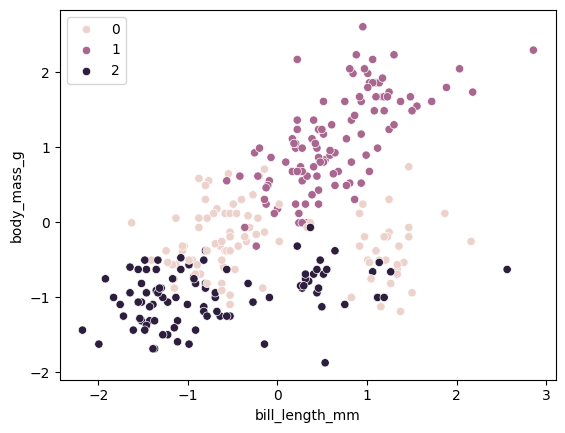

In [489]:
# ["island", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g", "sex"]
sns.scatterplot(data=x_train, x="bill_length_mm", y="body_mass_g", hue=kmeans.labels_)

<Axes: xlabel='flipper_length_mm', ylabel='body_mass_g'>

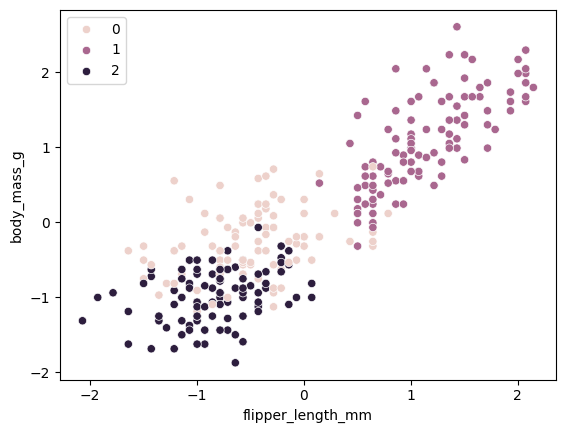

In [490]:
sns.scatterplot(
    data=x_train, x="flipper_length_mm", y="body_mass_g", hue=kmeans.labels_
)

### Evaluating our K-Means

**Silhouette score**: measure of how similar a data point is within-cluster (cohesion) compared to other clusters (separation).

The best value is 1 and the worst value is -1. 

Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.



In [491]:
silhouette_score(x_train, kmeans.labels_, metric="euclidean")

0.40890444164122536

### Finding the Best value for K


In [492]:
K = range(2, 20)
score = []

for k in K:
    model = KMeans(n_clusters=k, random_state=123, n_init="auto").fit(x_train)
    score.append(silhouette_score(x_train, model.labels_, metric="euclidean"))

Text(0, 0.5, 'silhouette_score')

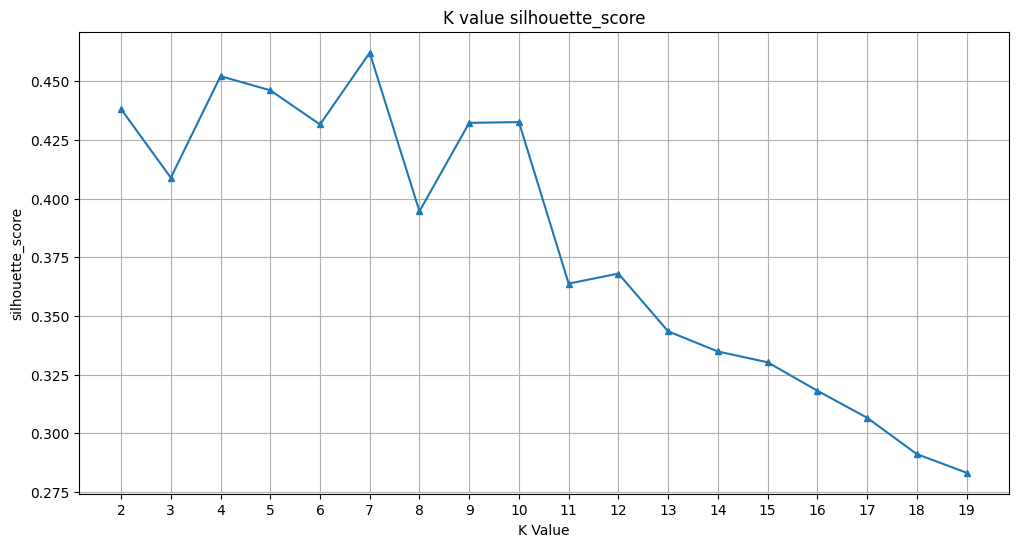

In [493]:
plt.figure(figsize=(12, 6))
plt.xticks(range(1, 20))
plt.plot(range(2, 20), score, marker="^", markersize=5)
plt.grid(True)
plt.title("K value silhouette_score")
plt.xlabel("K Value")
plt.ylabel("silhouette_score")